In [46]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "data/sarcasm/train-balanced-sarcasm.csv"

Загрузим датасет и изучим его

In [47]:
train_df = pd.read_csv(DATA_PATH)
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Присутствует пустые комментарии

In [49]:
train_df.dropna(subset=['comment'], inplace=True)

In [50]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [51]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

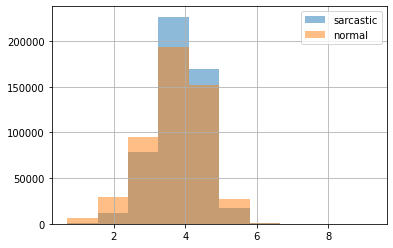

In [52]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

Давайте проанализируем, являются ли некоторые субреддиты в среднем более "саркастичными", чем другие

In [53]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [54]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)




,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


То же самое для авторов не дает большого понимания. За исключением того, что чьи - то комментарии были отобраны-мы можем видеть одинаковое количество саркастических и несаркастических комментариев.

In [55]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

In [56]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


#### Обучение модели

строим биграммы, устанавливаем ограничение на максимальное количество признаков и минимальную частоту слов

In [57]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [58]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 18.3 s, sys: 1.05 s, total: 19.4 s
Wall time: 32.1 s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.1s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [59]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 4.76 s, sys: 75.8 ms, total: 4.83 s
Wall time: 4.83 s


In [60]:
accuracy_score(y_valid, valid_pred)

0.7209668611047354

#### Разъяснение модели

In [61]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    Функция матрицы конфузий
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

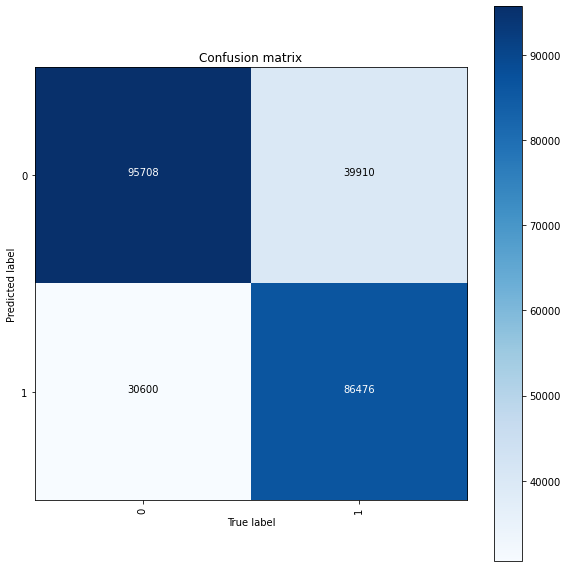

In [62]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [63]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+8.754,yes because
+7.638,obviously
+7.171,clearly
+6.967,yeah because
+6.804,totally
+6.242,because
+5.761,how dare
+5.643,right because
+5.133,good thing
+5.020,duh


#### Совершенствование модели

In [64]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

Применим TfidfVectorizer к комментариям и ответам по отдельности

In [65]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

In [66]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 22.6 s, sys: 390 ms, total: 23 s
Wall time: 23 s


In [67]:
X_train_texts.shape, X_valid_texts.shape

((758079, 50000), (252694, 50000))

In [68]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 2.53 s


In [69]:
X_train_subreddits.shape, X_valid_subreddits.shape

((758079, 13255), (252694, 13255))

Затем сложим все вместе.

In [70]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [71]:
X_train.shape, X_valid.shape

((758079, 63255), (252694, 63255))

In [34]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.6s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [78]:

from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class TextImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key, value):
        self.key = key
        self.value = value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.key] = X[self.key].fillna(self.value)
        return X

In [79]:
description = Pipeline([
                ('imputer', TextImputer('comment', '')),
                ('selector', ColumnSelector(key='comment')),
                ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2))
            ])

In [80]:
description.fit(X_train)

TypeError: 'coo_matrix' object is not subscriptable

In [35]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 106 ms


In [36]:
accuracy_score(y_valid, valid_pred)

0.7241802338005651

In [37]:
from sklearn.metrics import roc_auc_score,roc_curve,scorer

In [45]:
valid_pred[:, 1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [42]:
y_valid

469600    0
639137    0
240293    0
702254    1
889040    1
         ..
23988     0
408769    1
688966    0
107936    1
767875    1
Name: label, Length: 252694, dtype: int64

In [39]:
roc_auc_score(y_score=valid_pred[:, 1][:500], y_true=y_test.iloc[:500])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed